## **Upload Data to GC**

In [ ]:
from google.colab import auth
auth.authenticate_user()

!curl https://sdk.cloud.google.com | bash
!gcloud init

# CREATE ZIP FILE IN GOOGLE CLOUD
!curl https://zenodo.org/record/4442460/files/parler_data.zip?download=1 | gsutil cp - gs://nlpproject2022/posts.zip

from google.cloud import storage
from zipfile import ZipFile
from zipfile import is_zipfile
import io

def zipextract(bucketname, zipfilename_with_path):

    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucketname)

    destination_blob_pathname = zipfilename_with_path
    
    blob = bucket.blob(destination_blob_pathname)
    zipbytes = io.BytesIO(blob.download_as_string())

    if is_zipfile(zipbytes):
        with ZipFile(zipbytes, 'r') as myzip:
            for contentfilename in myzip.namelist():
                contentfile = myzip.read(contentfilename)
                blob = bucket.blob(zipfilename_with_path + "/" + contentfilename)
                blob.upload_from_string(contentfile)

zipextract("nlpproject2022", "posts.zip‏") # if the file is gs://mybucket/path/file.zip‏

## **Twitter API - Retrive data from past research**

git from the artical that collected the data:
https://github.com/samanthph/twitter-consp-theory-data

In [ ]:
!pip install tweepy
!pip3 install tweepy --upgrade

# LIBARAIES IMPORTS
import tweepy
import csv
import time
import requests
import pandas as pd
import json
import numpy as np


read_file = pd.read_csv (r'./tweets_txt.txt') # txt file contating the data from github repository 
read_file.to_csv (r'tweets_consp.csv', index=False) # convert txt to csv file 
tweets_consp = pd.read_csv('tweets_consp.csv')

# Enter relvant keys from twitter api
bearer_token=''
consumer_key = ''
consumer_key_secret = ''
access_token = ''
access_token_secret = ''

client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=consumer_key, 
                        consumer_secret=consumer_key_secret, 
                        access_token=access_token, 
                        access_token_secret=access_token_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)

ids_list = []
ids_list = list(tweets_consp['tweet_ID'])

# Did not get the academic API so we could extract only in batches
start_ind = 0
end_ind = 100
stop_ind = len(ids_list)

# print(ids_list)
all_data = pd.DataFrame()
# all_errors = pd.DataFrame()

while (start_ind != stop_ind):
  tweets = client.get_tweets(ids_list[start_ind:end_ind])
  tweets_dict = tweets.json()
  tweets_data = tweets_dict['data']
  df_data = pd.json_normalize(tweets_data)
  all_data = all_data.append(df_data)

  start_ind = end_ind
  end_ind = end_ind +100

  # DO NOT NEED THIS SECTION IT IS FOR DEBUGGING TO SEE WHAT TEXTS WE COULD NOT RETRIEVE !!
  # if "errors" in tweets_dict:
  #   print('inside errors')
  #   tweets_errors=tweets_dict['errors']
  # else:
  #   tweets_data = tweets_dict['data'] 
  # # Transform to pandas Dataframe
  # df_data = pd.json_normalize(tweets_data)
  # df_errors = pd.json_normalize(tweets_errors)
  # all_data = all_data.append(df_data)
  # all_errors = all_errors.append(df_errors)
all_data

In [ ]:
ids_lst = list(all_data["id"].astype(int)) # ids of texts we managed to extract
print(ids_lst)
extracted_df = tweets_consp.loc[tweets_consp["tweet_ID"].isin(ids_lst)]

extracted_df #try_df

merged = pd.merge(extracted_df, all_data, left_on ='tweet_ID', right_on = 'id')
merged = merged.drop_duplicates(subset = ['tweet_ID'], keep = 'first')
merged.to_csv('tweet_data_txt.csv', index = False) # Save a CSV file of all tweets containg texts we managed to extract. 1560 in total.

## **WORD2VEC** 

This section trains a word2vec model to expand a vocabulary found in past research that is related to conspiracies. This was done at early stages of the project.

The models were trained on conspiracy data that was found in kaggle.

Vocabulary from past research (link): https://onlinelibrary.wiley.com/doi/epdf/10.1002/mar.21542

Conspiracy data in kaggle: https://www.kaggle.com/datasets/gpreda/reddit-conspiracy-theory

### **IMPORTS AND INSTALLATIONS**

In [ ]:
!pip install nltk
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import re
from nltk import TweetTokenizer
import nltk

In [ ]:
nltk.download("stopwords")

In [ ]:
reddit = pd.read_excel('reddit_consp.csv')
reddit_text = reddit.text

### **FUNCTIONS TO CREATE CORPUS AND WORD DICTS**

In [ ]:
# We don't use this function
def get_file_data(stop_word_removal='no'):
    file_contents = []
    with open('jef_archer.txt') as f:
        file_contents = f.read()
    text = []
    for val in file_contents.split('.'):
        sent = re.findall("[A-Za-z]+", val)
        line = ''
        for words in sent:
            
            if stop_word_removal == 'yes': 
                if len(words) > 1 and words not in stop_words:
                    line = line + ' ' + words
            else:
                if len(words) > 1 :
                    line = line + ' ' + words
        text.append(line)
    return text

In [ ]:
def generate_dictinoary_data(text, word_to_index, index_to_word, corpus, count, vocab_size, stop_words):

    tt = TweetTokenizer()
    tokens = tt.tokenize(text)
    for word in tokens:
      if (word not in stop_words):
          word = word.lower()
          corpus.append(word)
          if word_to_index.get(word) == None:
              index_to_word.update ( {count : word })
              word_to_index.update ( {word : count})
              count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus, count

In [ ]:
# Initialize
word_to_index= dict()
index_to_word = dict()
corpus = []
count = 0
vocab_size = 0
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
# Create corpus and text dictionaries
for row_text in reddit_text:
  text = str(row_text)
  if (text!='Comment'):
    word_to_index,index_to_word,corpus,vocab_size,length_of_corpus, count = generate_dictinoary_data(text, word_to_index, index_to_word, corpus, count, vocab_size, stop_words)

print('Number of unique words:' , vocab_size)
print('word_to_index : ',word_to_index)
print('index_to_word : ',index_to_word)
print('corpus:',corpus)
print('Length of corpus :',length_of_corpus)

In [ ]:
print(index_to_word)
tt = TweetTokenizer()
tokens = tt.tokenize(reddit_text[0])
print(str(tokens))

### **Encoding**

In [ ]:
def get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index):
    
    #Create an array of size = vocab_size filled with zeros
    trgt_word_vector = np.zeros(vocab_size)
    
    #Get the index of the target_word according to the dictionary word_to_index. 
    #If target_word = best, the index according to the dictionary word_to_index is 0. 
    #So the one hot vector will be [1, 0, 0, 0, 0, 0, 0, 0, 0]
    index_of_word_dictionary = word_to_index.get(target_word) 
    
    #Set the index to 1
    trgt_word_vector[index_of_word_dictionary] = 1
    
    #Repeat same steps for context_words but in a loop
    ctxt_word_vector = np.zeros(vocab_size)
    
    
    for word in context_words:
        index_of_word_dictionary = word_to_index.get(word) 
        ctxt_word_vector[index_of_word_dictionary] = 1
        
    return trgt_word_vector,ctxt_word_vector

### **Training Functions**

In [ ]:
#Note : Below comments for trgt_word_index, ctxt_word_index are with the above sample text for understanding the code flow
def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,sample=None):

    training_data =  []
    training_sample_words =  []
    for i,word in enumerate(corpus):

        index_target_word = i
        target_word = word
        context_words = []

        #when target word is the first word
        if i == 0:  

            # trgt_word_index:(0), ctxt_word_index:(1,2)
            context_words = [corpus[x] for x in range(i + 1 , window_size + 1)] 


        #when target word is the last word
        elif i == len(corpus)-1:

            # trgt_word_index:(9), ctxt_word_index:(8,7), length_of_corpus = 10
            context_words = [corpus[x] for x in range(length_of_corpus - 2 ,length_of_corpus -2 - window_size  , -1 )]

        #When target word is the middle word
        else:

            #Before the middle target word
            before_target_word_index = index_target_word - 1
            for x in range(before_target_word_index, before_target_word_index - window_size , -1):
                if x >=0:
                    context_words.extend([corpus[x]])

            #After the middle target word
            after_target_word_index = index_target_word + 1
            for x in range(after_target_word_index, after_target_word_index + window_size):
                if x < len(corpus):
                    context_words.extend([corpus[x]])


        trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index)
        training_data.append([trgt_word_vector,ctxt_word_vector])   
        
        if sample is not None:
            training_sample_words.append([target_word,context_words])   
        
    return training_data,training_sample_words

In [ ]:
# Generate training data based on window size
window_size = 2 # CHECK DIFFERENT WINDOW SIZES
training_data,training_sample_words = generate_training_data(corpus,2,vocab_size,word_to_index,length_of_corpus,'yes')

for i in range(len(training_data)):
    print('*' * 50)
    print('Target word:%s . Target vector: %s ' %(training_sample_words[i][0],training_data[i][0]))
    print('Context word:%s . Context  vector: %s ' %(training_sample_words[i][1],training_data[i][1]))

In [ ]:
def forward_prop(weight_inp_hidden,weight_hidden_output,target_word_vector):
    
    #target_word_vector = x , weight_inp_hidden =  weights for input layer to hidden layer  
    hidden_layer = np.dot(weight_inp_hidden.T, target_word_vector)
    
    #weight_hidden_output = weights for hidden layer to output layer
    u = np.dot(weight_hidden_output.T, hidden_layer)
    
    y_predicted = softmax(u)
    
    return y_predicted, hidden_layer, u
  
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [ ]:
def backward_prop(weight_inp_hidden,weight_hidden_output,total_error, hidden_layer, target_word_vector,learning_rate):
    
    dl_weight_inp_hidden = np.outer(target_word_vector, np.dot(weight_hidden_output, total_error.T))
    dl_weight_hidden_output = np.outer(hidden_layer, total_error)
    
    # Update weights - training process
    weight_inp_hidden = weight_inp_hidden - (learning_rate * dl_weight_inp_hidden)
    weight_hidden_output = weight_hidden_output - (learning_rate * dl_weight_hidden_output)
    
    return weight_inp_hidden,weight_hidden_output

In [ ]:
def calculate_error(y_pred,context_words):
    
    total_error = [None] * len(y_pred)
    index_of_1_in_context_words = {}
    
    for index in np.where(context_words == 1)[0]:
        index_of_1_in_context_words.update ( {index : 'yes'} )
        
    number_of_1_in_context_vector = len(index_of_1_in_context_words)
    
    for i,value in enumerate(y_pred):
        
        if index_of_1_in_context_words.get(i) != None:
            total_error[i]= (value-1) + ( (number_of_1_in_context_vector -1) * value)
        else:
            total_error[i]= (number_of_1_in_context_vector * value)
            
            
    return  np.array(total_error)

In [ ]:
def calculate_loss(u,ctx):
    
    sum_1 = 0
    for index in np.where(ctx==1)[0]:
        sum_1 = sum_1 + u[index]
    
    sum_1 = -sum_1
    sum_2 = len(np.where(ctx==1)[0]) * np.log(np.sum(np.exp(u)))
    
    total_loss = sum_1 + sum_2
    return total_loss

In [ ]:
def train(word_embedding_dimension,window_size,epochs,training_data,learning_rate,disp = 'yes',interval=-1):
    
    weights_input_hidden = np.random.uniform(-1, 1, (vocab_size, word_embedding_dimension))
    weights_hidden_output = np.random.uniform(-1, 1, (word_embedding_dimension, vocab_size))
    
    
    #For evaluation - extract weigts and ephoc loss
    epoch_loss = []
    weights_1 = []
    weights_2 = []
    
    for epoch in range(epochs):
        loss = 0

        for target,context in training_data:
            y_pred, hidden_layer, u = forward_prop(weights_input_hidden,weights_hidden_output,target)

            total_error = calculate_error(y_pred, context)

            weights_input_hidden,weights_hidden_output = backward_prop(
                weights_input_hidden,weights_hidden_output ,total_error, hidden_layer, target,learning_rate
            )

            loss_temp = calculate_loss(u,context)
            loss += loss_temp
        
        epoch_loss.append( loss )
        weights_1.append(weights_input_hidden)
        weights_2.append(weights_hidden_output)
        
        if disp == 'yes':
            if epoch ==0 or epoch % interval ==0 or epoch == epochs -1:
                print('Epoch: %s. Loss:%s' %(epoch,loss))
    return epoch_loss,np.array(weights_1),np.array(weights_2)

In [ ]:
# Input vector, returns nearest word(s)
def cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word):
    
    #Get the index of the word from the dictionary
    index = word_to_index[word]
    
    #Get the correspondin weights for the word
    word_vector_1 = weight[index]
    
    
    word_similarity = {}

    for i in range(vocab_size):
        
        word_vector_2 = weight[i]
        
        theta_sum = np.dot(word_vector_1, word_vector_2)
        theta_den = np.linalg.norm(word_vector_1) * np.linalg.norm(word_vector_2)
        theta = theta_sum / theta_den
        
        word = index_to_word[i]
        word_similarity[word] = theta
    
    return word_similarity 

In [ ]:
def print_similar_words(top_n_words,weight,msg,words_subset):
    
    columns=[]
    
    for i in range(0,len(words_subset)):
        columns.append('similar:' +str(i+1) )
        
    df = pd.DataFrame(columns=columns,index=words_subset)
    df.head()
    
    row = 0
    for word in words_subset:
        
        #Get the similarity matrix for the word: word
        similarity_matrix = cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word)
        col = 0
        
        #Sort the top_n_words
        words_sorted = dict(sorted(similarity_matrix.items(), key=lambda x: x[1], reverse=True)[1:top_n_words+1])
        
        #Create a dataframe to display the similarity matrix
        for similar_word,similarity_value in words_sorted.items():
            df.iloc[row][col] = (similar_word,round(similarity_value,2))
            col += 1
        row += 1
    styles = [dict(selector='caption', 
    props=[('text-align', 'center'),('font-size', '20px'),('color', 'red')])] 
    df = df.style.set_properties(**
                       {'color': 'green','border-color': 'blue','font-size':'14px'}
                      ).set_table_styles(styles).set_caption(msg)
    return df

In [ ]:
def word_similarity_scatter_plot(index_to_word,weight,plot_title,fig,axes):
    
    labels = []
    tokens = []
    
    for key,value in index_to_word.items():
        tokens.append(weight[key])
        labels.append(value)
        
    #TSNE : Compressing the weights to 2 dimensions to plot the data
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    for i in range(len(x)):
        axes.scatter(x[i],y[i])
        axes.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    axes.set_title(plot_title, loc='center')

In [ ]:
def plot_epoch_loss(lbl,loss_epoch,plot_title,path):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    i = 0
    fig = plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k',dpi=80)
    plt.suptitle('Epoch vs Loss',fontsize=16)
    
    for key,loss in loss_epoch.items():
        
        
        epoch_count = range(1, len(loss) + 1)

        plt.plot(epoch_count, loss, 'r-',color=colors[i],linewidth=2.0,label = lbl + str(key))

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        i += 1

    plt.legend(framealpha=1, frameon=True,fontsize='large',edgecolor="inherit",shadow=True)
    plt.title(plot_title)
    plt.savefig(path+plot_title +'.png')
    plt.show()
    plt.close()   

In [ ]:
path_to_save = './'
path_to_save_scatter_plot = './'

### **Tune Dimensions**

In [ ]:
window_size = 2
epochs = 100
learning_rate = 0.01

In [ ]:
dimensions = [10,30,50]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying dimension", fontsize=16)
row=0
col=0
for dim in dimensions:
    
    epoch_loss,weights_1,weights_2 = train(dim,window_size,epochs,training_data,learning_rate)
    loss_epoch.update( {dim: epoch_loss} )
    
    word_similarity_scatter_plot(
        index_to_word,
        weights_1[epochs -1],
        'dimension_' + str(dim) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
        fig,
        axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1

plt.savefig(path_to_save_scatter_plot+'varying_dim' +'.png')        
plt.show()
plot_epoch_loss('dim:',loss_epoch,'epochs_' + str(epochs) + '_window_size_' +str(window_size),path_to_save)

In [ ]:
dimension = 50
epochs = 100
learning_rate = 0.01

### **Tune Window Size**

In [ ]:
window_size = [2,3,5,7]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying window_size", fontsize=16)
row=0
col=0
for ws in window_size:
    
    training_data,training_sample_words = generate_training_data(corpus,ws,vocab_size,word_to_index,length_of_corpus)
    
    epoch_loss,weights_1,weights_2 = train(dimension,ws,epochs,training_data,learning_rate)
    loss_epoch.update( {ws: epoch_loss} )
    
    word_similarity_scatter_plot(
        index_to_word,
        weights_1[epochs -1],
        'dimension_20_' + '_epochs_' + str(epochs) + '_window_size_' +str(ws),
        fig,
        axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1
plt.savefig(path_to_save_scatter_plot+'varying_window_size' +'.png')                
plt.show()
plot_epoch_loss('window_size_',loss_epoch,'_epochs_' + str(epochs) + '_dimension_20' ,path_to_save)

### **Tune Epochs**

In [ ]:
window_size = 2
dimension = 50
learning_rate = 0.01

In [ ]:
epochs = [100]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying epochs", fontsize=16)
row=0
col=0
for epoch in epochs:
    
    epoch_loss,weights_1,weights_2 = train(dimension,window_size,epoch,training_data,learning_rate)
    loss_epoch.update( {epoch: epoch_loss} )
    
    word_similarity_scatter_plot(
        index_to_word,
        weights_1[epoch -1],
        'dimension_' + str(dimension) + '_epochs_' + str(epoch) + '_window_size_' +str(window_size),
        fig,
        axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1
plt.savefig(path_to_save_scatter_plot+'varying_epochs' +'.png')                
plt.show()
plot_epoch_loss('epochs_',loss_epoch,'dimension_' + str(dimension) + '_window_size_' +str(window_size),path_to_save)

### **Run the final config and find similar words**

In [ ]:
# 
epochs = 100
top_n_words = 16
dimension = 50
window_size = 2
learning_rate = 0.01
path_to_save_scatter_plot = './'

In [ ]:
# The word subset contains only words that were found in Parler dataset.
words_subset = ['conspiracy', 'theories', 'destroy', 'dictatorship', 'control', 'people', 'government', 'manipulate', 'mechanism',
                 'propaganda', 'know', 'money', 'school', 'country', 'state', 'terror']

words_subset = []
words_subset = np.random.choice(list(word_to_index.keys()),top_n_words)
print(len(words_subset))

In [ ]:
def word_similarity_scatter_plot_bigger_corpus(index_to_word,weight,plot_title,path):
    
    labels = []
    tokens = []
    
    for key,value in index_to_word.items():
        tokens.append(weight[key])
        labels.append(value)
        
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    x = x[0:200]
    y = y[0:200]
    
    plt.figure(figsize=(20, 30)) 

    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                    family='fantasy')
    plt.title(plot_title)
    plt.savefig(path+plot_title +'.png')
    plt.close()   

In [ ]:
loss_epoch = {}
dataframe_sim = []

epoch_loss,weights_1,weights_2 = train(dimension,window_size,epochs,training_data,learning_rate,'yes',50)
loss_epoch.update( {'yes': epoch_loss} )

word_similarity_scatter_plot_bigger_corpus(
    index_to_word,
    weights_1[epochs -1],
    'Stopwords_removed_dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save_scatter_plot
)

df = print_similar_words(
    top_n_words,
    weights_1[epochs - 1],
    'sim_matrix for : Stopwords_removed_dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    words_subset
)
dataframe_sim.append(df)

plot_epoch_loss(
    'Stopwords_removed_',
    loss_epoch,
    'Without_Stopwords_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save
)

In [ ]:
for i in range(len(dataframe_sim)):
    display(dataframe_sim[i])

## **ZERO SHOT**
This section contains Zero shot for multilabel classification of the topic the sentence is related to. 
The aim is to find the sentences that contain similar topics to twitter dataset so that we can increase the preformance of the models.

In [ ]:
!pip install transformers
from transformers import pipeline

In [ ]:
classifier = pipeline ("zero-shot-classification", model = "facebook/bart-large-mnli") # Run zero shot to detect classes similar to twitter data
labels = [] # zero shot labels
parler_data = pd.read_excel('union.xlsx') # Read all tagged parler data (with all conspiracy classes)
texts = parler_data.text
label_candidate = ['climate change', 'COVID', 'Maxwell','black', 'politics']

for ind,text in enumerate(texts):
    print(ind)
    input_sequence = text
    labels.append(classifier(input_sequence, label_candidate)['labels'][0])

parler_data['conspiracy_label'] = labels # add the class label to dataframe

## **Augmentation**
This section contains text augmentation to deal with unbalanced training data and the small dataset that we have labeled from Parler.

In [ ]:
!pip install nlpaug
!pip install transformers

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm_colab
import nlpaug 
import nlpaug.augmenter.word as naw

In [ ]:
# Example of augmentation
text = 'Black men are taught that a word justifies all forms of violence against white people'
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
augmented_text = aug.augment(text)

In [ ]:
train = pd.read_csv('train_data.csv')

def augment_text(df,samples=600):
    new_text=[]
    aug1 = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

    # Other 2 augmentations that were tried and did not preform well:
    # aug2 = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")
    # aug3 = nas.ContextualWordEmbsForSentenceAug(model_path='GPT2')

    # selecting the minority class samples
    df_n=df[df.label==0].reset_index(drop=True)

    # data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):

            text = df_n.iloc[i]['text']
            augmented_text = aug1.augment(text)
            new_text.append(augmented_text)

            # augmented_text = aug2.augment(text)
            # new_text.append(augmented_text)
            # augmented_text = aug3.augment(text)
            # new_text.append(augmented_text)

    # new dataframe containing augmentations
    new=pd.DataFrame({'text':new_text,'label':0})
    return new

aug_df = augment_text(train) # Create augmentation dataframe of training data.

## **EDA**

This section contains main graphs, descriptions and etc. that were extracted to describe the data we are working with.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

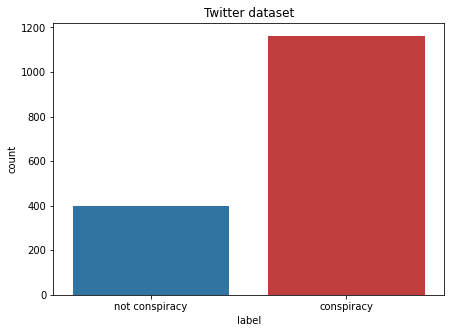

conspiracy        1162
not conspiracy     398
Name: label, dtype: int64


In [16]:
# Twitter conspiracy data count plot for label
twitter_only = pd.read_csv('twitter_consp_txt.csv')
twitter_only.label = pd.Series(np.where(twitter_only.label.values == 1, 'conspiracy', 'not conspiracy'),
          twitter_only.index)

sns.countplot(data=twitter_only, x="label",palette={'not conspiracy':"tab:blue",'conspiracy':"tab:red"}).set(title='Twitter dataset')
plt.show()
s = twitter_only['label'].value_counts()
print(s)

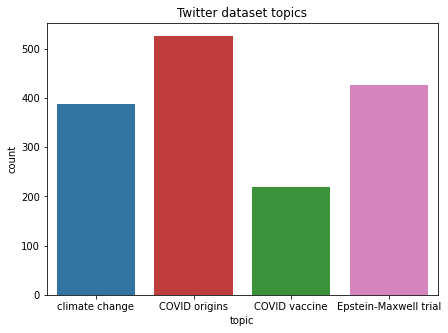

COVID origins            526
Epstein-Maxwell trial    426
climate change           388
COVID vaccine            220
Name: topic, dtype: int64


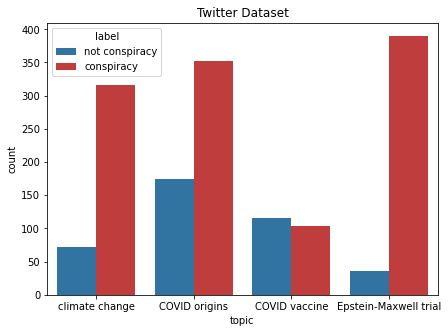

In [17]:
# Twitter conspiracy data count plot for conspiracy type 
# twitter_only = pd.read_csv('twitter_consp_txt.csv')
# twitter_only.topic
# 0: climate change 1: COVID origins 2: COVID vaccine 3: Epstein
def to_str(x):
    if x==0: return 'climate change'
    if x==1: return 'COVID origins'
    if x==2: return 'COVID vaccine'
    if x==3: return 'Epstein-Maxwell trial'

twitter_only['topic'] = twitter_only['topic'].apply(to_str)

plt.rcParams['figure.figsize'] = (7, 5)
sns.countplot(data=twitter_only, x="topic",palette={'climate change':"tab:blue",'COVID origins':"tab:red", 'COVID vaccine': "tab:green", 'Epstein-Maxwell trial': "tab:pink"}).set(title='Twitter dataset topics')
plt.show()
s = twitter_only['topic'].value_counts()
print(s)

plot = sns.countplot(data=twitter_only, x='topic', hue='label', palette={'not conspiracy':"tab:blue",'conspiracy':"tab:red"})
plot.set(title='Twitter Dataset')
fig = plot.get_figure()
fig.savefig('twitter.png')

In [4]:
# All conspiracy tagged data
twitter_and_parler = pd.read_excel('twitter_and_parler.xlsx')
sns.countplot(data=twitter_and_parler, x="label",palette={0:"tab:blue",1:"tab:red"}).set(title='Twitter and Parler')
plt.show()
s = twitter_and_parler['label'].value_counts()
print(s)

FileNotFoundError: ignored

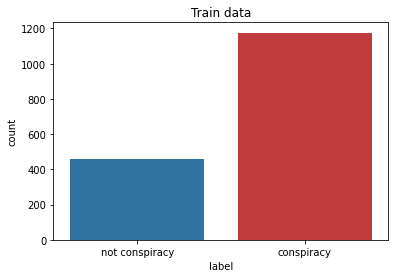

conspiracy        1176
not conspiracy     460
Name: label, dtype: int64


In [5]:
# Training data before augmentations- twitter and Parler
train = pd.read_csv('train_data.csv')
train.label = pd.Series(np.where(train.label.values == 1, 'conspiracy', 'not conspiracy'),
          train.index)

sns.countplot(data=train, x="label",palette={'not conspiracy':"tab:blue",'conspiracy':"tab:red"}).set(title='Train data')
plt.show()
s = train['label'].value_counts()
print(s)

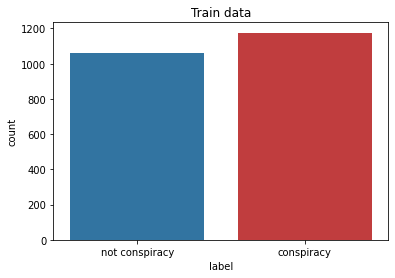

conspiracy        1176
not conspiracy    1060
Name: label, dtype: int64


In [10]:
# Training data after augmentations- twitter and Parler
train = pd.read_csv('train_data_aug.csv')
train.label = pd.Series(np.where(train.label.values == 1, 'conspiracy', 'not conspiracy'),
          train.index)

plot = sns.countplot(data=train, x="label",palette={'not conspiracy':"tab:blue",'conspiracy':"tab:red"})
plot.set(title='Train data')
plt.show()
s = train['label'].value_counts()
print(s)
plot.get_figure().savefig('balanced.png')

In [8]:
# Test data - Parler posts
test_data = pd.read_csv('test_data_parler.csv')
test_data.label = pd.Series(np.where(parler_only.label.values == 1, 'conspiracy', 'not conspiracy'),
          parler_only.index)

sns.countplot(data=test_data, x="label",palette={'not conspiracy':"tab:blue",'conspiracy':"tab:red"}).set(title='Parler test data')
plt.show()
s = test_data['label'].value_counts()
print(s)

NameError: ignored

## **BERT for Conspiracy Detection**

This section contains fine-tunning BERT for conspiracy text classification.
The training data contains tagged data from twitter (from past research - see section twitter api) and tagged posts from Parler tagged by our team.

In [ ]:
# INSTALLATIONS and IMPORTS
!pip install -q git+https://github.com/gmihaila/ml_things.git
!pip install transformers
!pip install matplotlib==3.1.3

import io
import os
import torch
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          BertModel,
                          BertConfig,
                          BertTokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          BertForSequenceClassification)

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

set_seed(42) # Set seed

In [ ]:
# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 2
batch_size = 16
max_length = 512 # For padding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'bert-base-uncased' #'bert-base-uncased' or 'GoNLP/HateBERT'
# Dictionary of labels and their id - this will be used to convert.
labels_ids = {'neg': 0, 'pos': 1}
n_labels = len(labels_ids)

In [ ]:
class OurDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, texts, labels, use_tokenizer):

    ########### OUR DATA ##############
    sentences = texts

  # We need to add special tokens at the beginning and end of each sentence for BERT to work properly in sentence classification
    sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
    self.texts = sentences
    self.labels = labels
    # print(self.texts)
    # print(self.labels)
    self.n_examples = len(self.labels)

    return

  def __len__(self): # Returns the number of examples
    return self.n_examples

  def __getitem__(self, item): 
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class BertClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # # Encode all labels using label encoder.
        # labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  global model
  predictions_labels = []
  true_labels = []

  # Total loss for this epoch
  total_loss = 0

  # Training mode
  model.train()
  for batch in tqdm(dataloader, total=len(dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a backward pass
    model.zero_grad()
    outputs = model(**batch)

    loss, logits = outputs[:2] # pull loss and logits (logits is used to calc training accuracy)
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip norm if the gradients to 1.0. - prevent "exploding gradients"
    optimizer_.step()
    scheduler_.step()
    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for evaluation.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  global model
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  model.eval()

  for batch in tqdm(dataloader, total=len(dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    with torch.no_grad(): # Don't compute gradients (to save memory)        

        outputs = model(**batch)
        loss, logits = outputs[:2] # loss and logits (logits to compute validation accuracy)
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

  # Calculate the average loss over the validation data
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for evaluation
  return true_labels, predictions_labels, avg_epoch_loss

In [ ]:
 #Get model configuration
print('Loading configuraiton...')
model_config = BertConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer
print('Loading tokenizer...')
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "right"

# GET model
print('Loading model...')
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

#Load model to device
model.to(device)
print('Model loaded to `%s`'%device)

In [ ]:
train_data = pd.read_excel('train_data.xlsx') # training_hate.xlsx
train_data.text = train_data.text.astype(str)
train_texts = train_data.text.values
train_labels = train_data.label.values
x_train, x_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)


Bert_classificaiton_collator = BertClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

print('Dealing with Train...')
# Create dataset
train_dataset = OurDataset(x_train, y_train, use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=Bert_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create  dataset
valid_dataset =  OurDataset(x_test, y_test,  use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=Bert_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # default is 5e-5, tuned also other values
                  eps = 1e-8 # default is 1e-8, tuned also other values
                  )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

**Test data - parler tagged conspiracy data**

In [ ]:
test_data = pd.read_csv('test_parler.csv')

test_texts = test_data.text.values
test_anno = test_data.hate_label.values # change to hate annotations


print('Dealing with Test...')
# Create dataset
test_dataset =  OurDataset(test_texts, test_anno,  use_tokenizer=tokenizer)
print('Created `test_dataset` with %d examples!'%len(test_dataset))

# Move pytorch dataset into dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=Bert_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader))

In [ ]:
true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader, device)

# Create the evaluation report
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)

# Plot confusion matrix
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );

fpr, tpr, thresholds = metrics.roc_curve(true_labels, predictions_labels, pos_label=1)
metrics.auc(fpr, tpr)

## **GPT2 For Conspiracy Detection**

This section contains fine-tunning GPT2 model for conspiracy text classification. 
Train and test data contains same data that was used for BERT.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/gmihaila/ml_things.git

import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

In [ ]:
# Config
epochs = 2
batch_size = 16
max_length = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'
labels_ids = {'neg': 0, 'pos': 1}
n_labels = len(labels_ids)

set_seed(42)

In [ ]:
class OurDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, texts, labels, use_tokenizer):

    ########### OUR DATA ##############
    self.texts = texts
    self.labels = labels
    print(self.texts)
    print(self.labels)
    # Number of exmaples.
    self.n_examples = len(self.labels)

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.train()

  for batch in tqdm(dataloader, total=len(dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    model.zero_grad()
    outputs = model(**batch)


    loss, logits = outputs[:2] # loss value and logits
    total_loss += loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent exploding gradients

    optimizer_.step()
    scheduler_.step()
    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  avg_epoch_loss = total_loss / len(dataloader) # AVG ephoc loss
  
  # Return all true labels and prediction for future evaluations
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """


  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.eval()

  for batch in tqdm(dataloader, total=len(dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations
  return true_labels, predictions_labels, avg_epoch_loss

In [ ]:
#Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token # eos token from GPT2

# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('train_data_aug.csv')
train_texts = train_data.text.values
train_labels = train_data.label.values
x_train, x_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)


# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)
# Training
print('Dealing with Train...')
train_dataset = OurDataset(x_train, y_train, use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

# Validation
print('Dealing with Validation...')
valid_dataset =  OurDataset(x_test, y_test,  use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8 
                  )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# save accuracies and losses
all_loss = {'train_loss':[], 'val_loss':[]} 
all_acc = {'train_acc':[], 'val_acc':[]}

# Training process
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()


  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

**Test GPT2 conspiracy model**

In [ ]:
test_data = pd.read_csv('test_data_parler.csv')

test_texts = test_data.text.values
test_anno = test_data.label.values

print('Dealing with Test...')
# Create pytorch dataset.
test_dataset =  OurDataset(test_texts, test_anno,  use_tokenizer=tokenizer)
print('Created `test_dataset` with %d examples!'%len(test_dataset))

# Move pytorch dataset into dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader))

In [ ]:
true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader, device)
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)

# Plot confusion matrix
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );

fpr, tpr, thresholds = metrics.roc_curve(true_labels, predictions_labels, pos_label=1)
metrics.auc(fpr, tpr)

## **Hate VS Conspiracy**
Analyzing hate vs conspiracy in posts - trying to find a relation in the mode outputs and tagged data.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

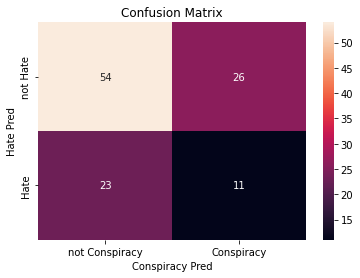

In [ ]:
pred = pd.read_excel('test_pred.xlsx') # model predictions
hate_pred = pred.hate_pred.values # hate
consp_pred = pred.consp_pred.values # conspiracies

# predictions confusion matrix.
cm = confusion_matrix(hate_pred, consp_pred) 
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Conspiracy Pred');ax.set_ylabel('Hate Pred'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not Conspiracy', 'Conspiracy']); ax.yaxis.set_ticklabels(['not Hate', 'Hate']);

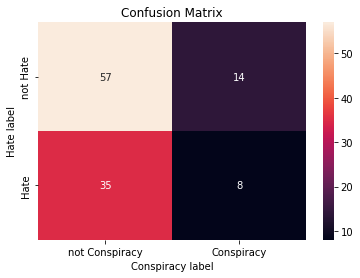

In [ ]:
# Labels confusion matrix.
pred['hate_label'] = pd.Series(np.where(pred.label_mean.values <=3, 0, 1),
          pred.index)

hate_label = pred.hate_label.values # hate label
consp_label = pred.label_consp.values # conspiracy label

# Labels confusion matrix.
cm = confusion_matrix(hate_label, consp_label)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Conspiracy label');ax.set_ylabel('Hate label'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not Conspiracy', 'Conspiracy']); ax.yaxis.set_ticklabels(['not Hate', 'Hate']);

**Try to find label mean connection**

In [ ]:
pred = pd.read_excel('test_pred.xlsx') # Predictions

hate_and_consp = pred[(pred.hate_pred == 1) & (pred.consp_pred == 1)] # conspiracy and hate predictions only
hate_means = hate_and_consp.label_mean.values
hate_means